Generates the core files for computing axion survival

In [100]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import AutoMinorLocator
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import RegularGridInterpolator
import multiprocessing

In [2]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'cmr10'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["axes.formatter.use_mathtext"] = True

In [51]:
g0 = 1e-10
g = 1e-7

In [15]:
cm_per_Rsun = 6.957e10
g_per_Msun = 1.998e33
G_cgs = 6.674e-8
c_cgs = 2.998e10
E0_ev = 4.402e5
mp_per_Msun = 8.41e-58

In [4]:

isotopes = [
    'c12', 
    'o16', 
    'ne20', 
    'na23',
]


trace = [
    'na23',
]

color = {
    'c12': 'slateblue',
    'o16': 'orangered',
    'ne20': 'forestgreen',
    'na23': 'darkorange',
}


ls = {
    'c12': 'solid',
    'o16': 'dashed',
    'ne20': 'dotted',
    'na23': 'solid',
}


labels = {
    'c12': '$^{12}$C',
    'o16': '$^{16}$O',
    'ne20': '$^{20}$Ne',
    'na23': '$^{23}$Na',
}

In [135]:
ms = (9, 10, 11, 12)
times = ( 1000, 600, 300, 100 )
indices = np.array((
    (2000, 1780, 1590, 1520),
    (2040, 1820, 1660, 1550),
    (2130, 1860, 1700, 1610),
    (2210, 1950, 1750, 1650),
))

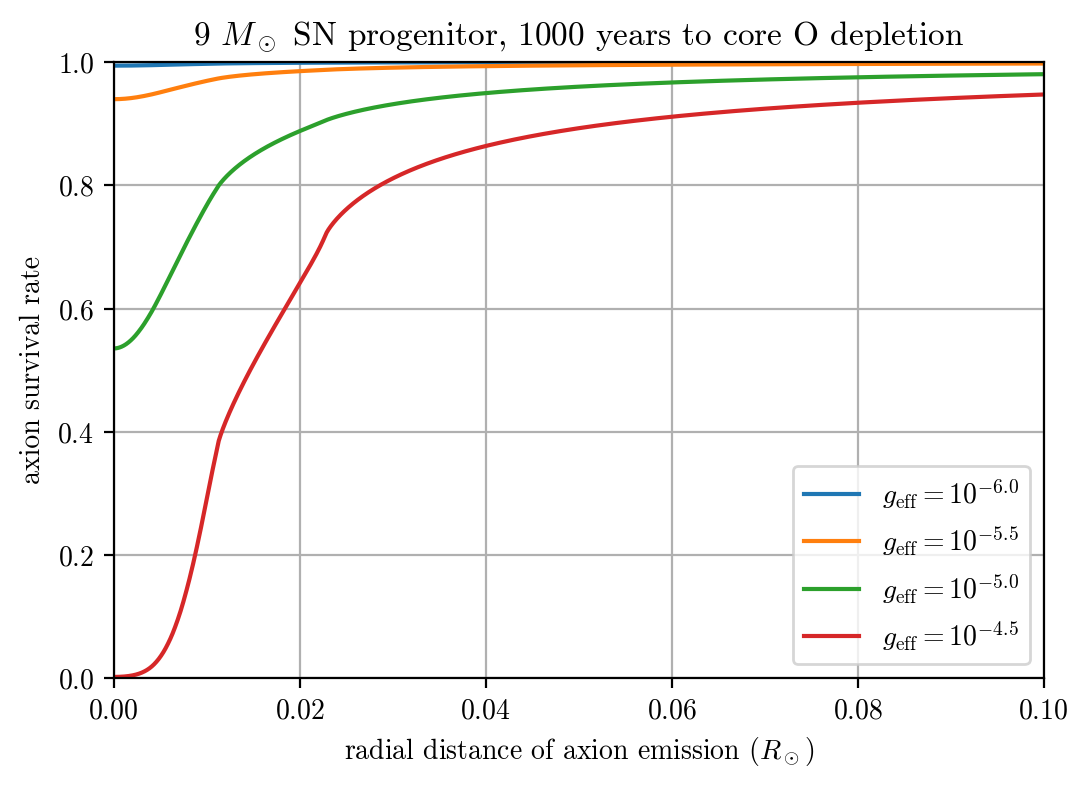

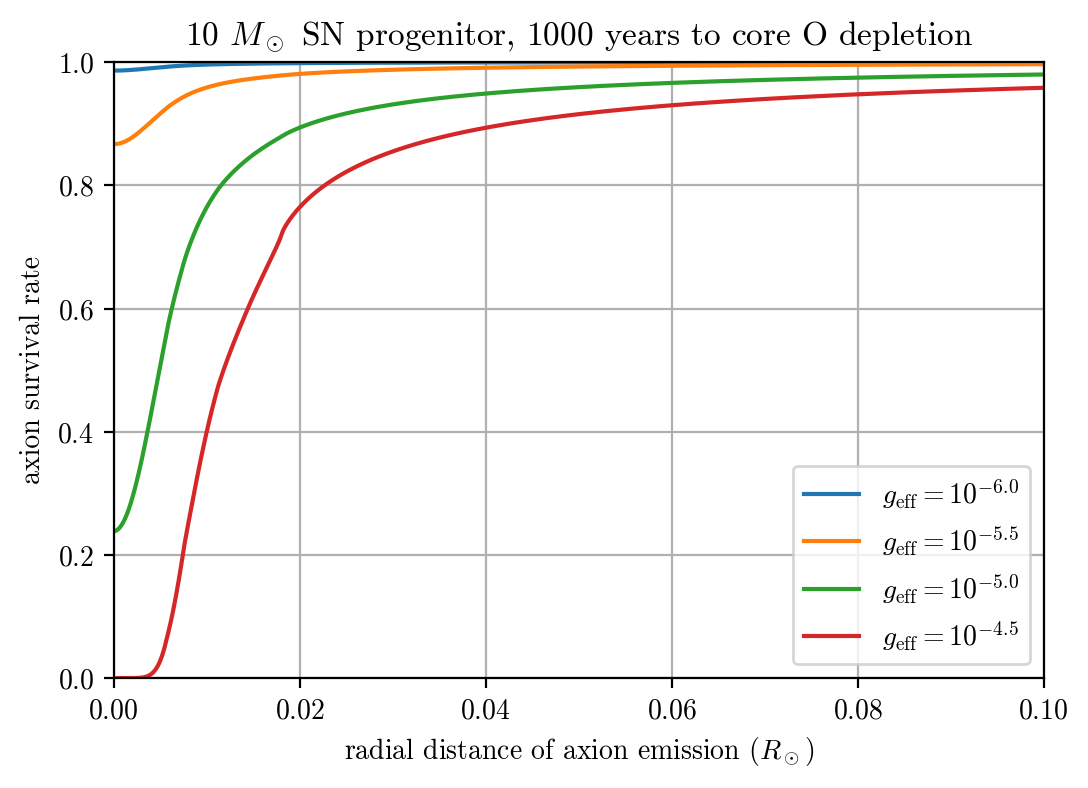

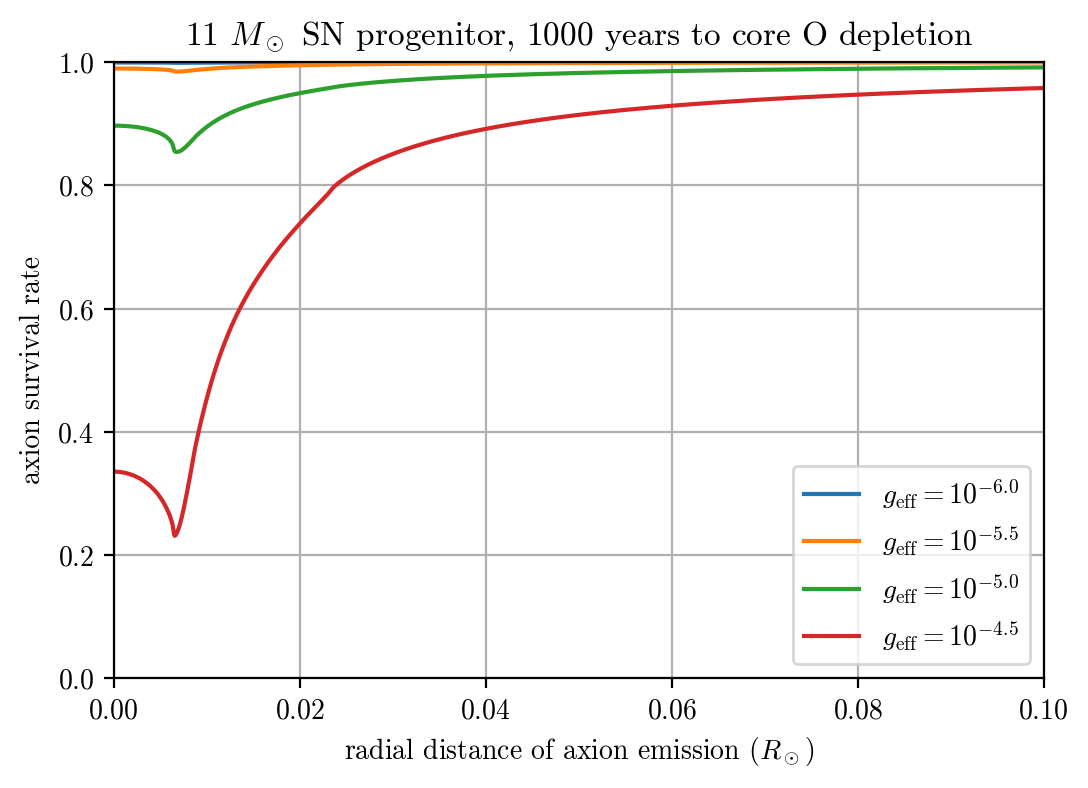

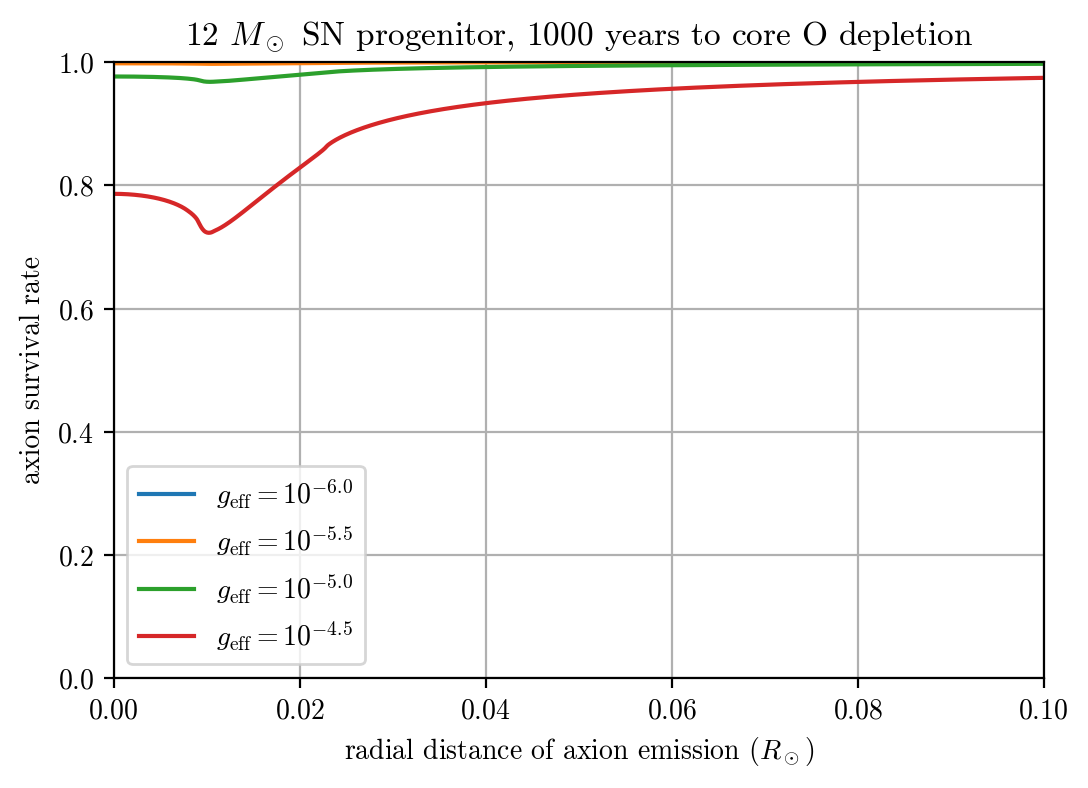

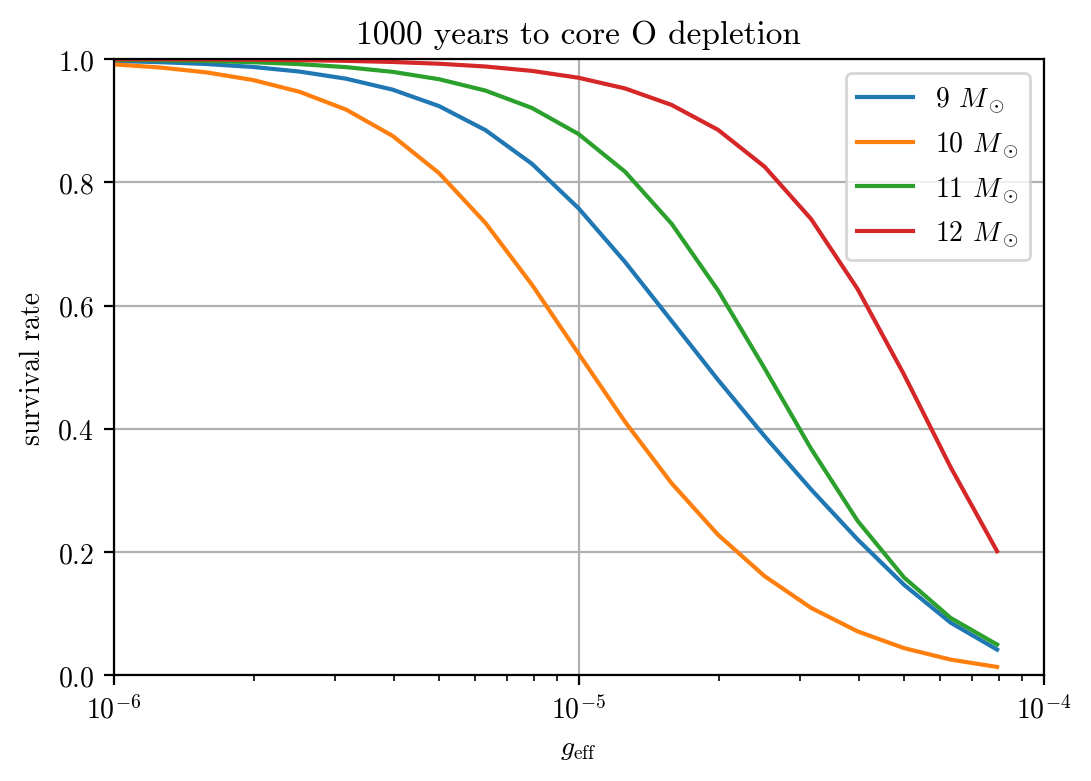

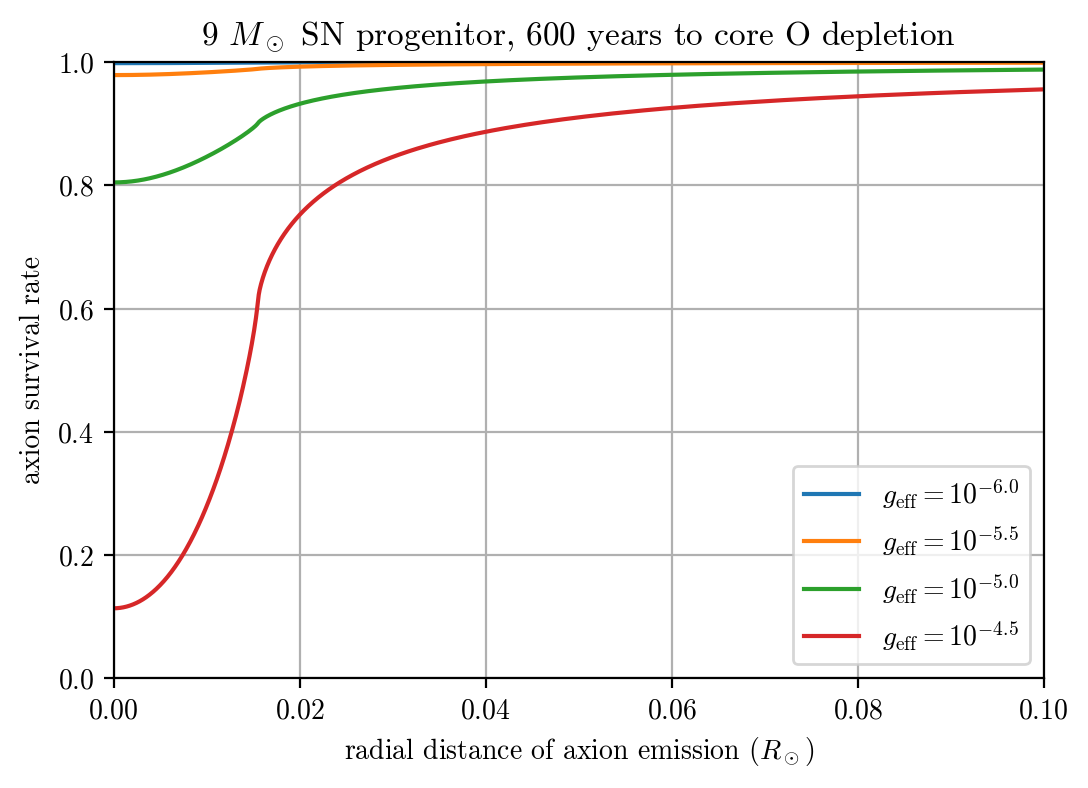

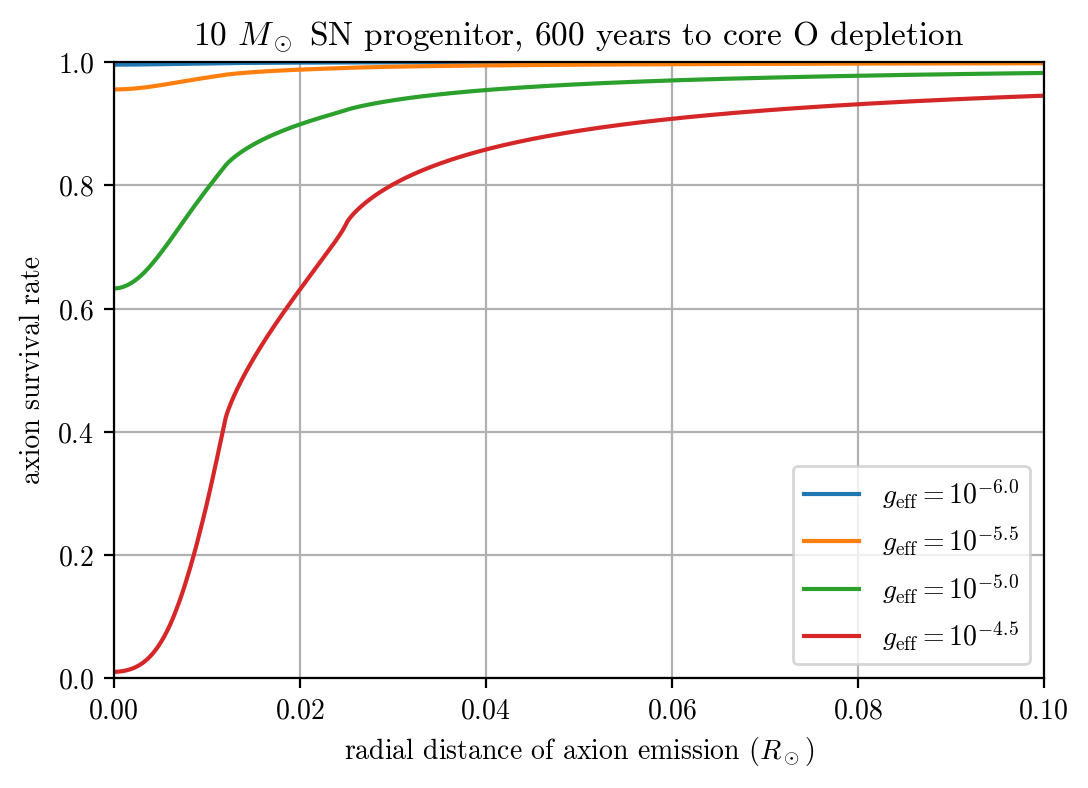

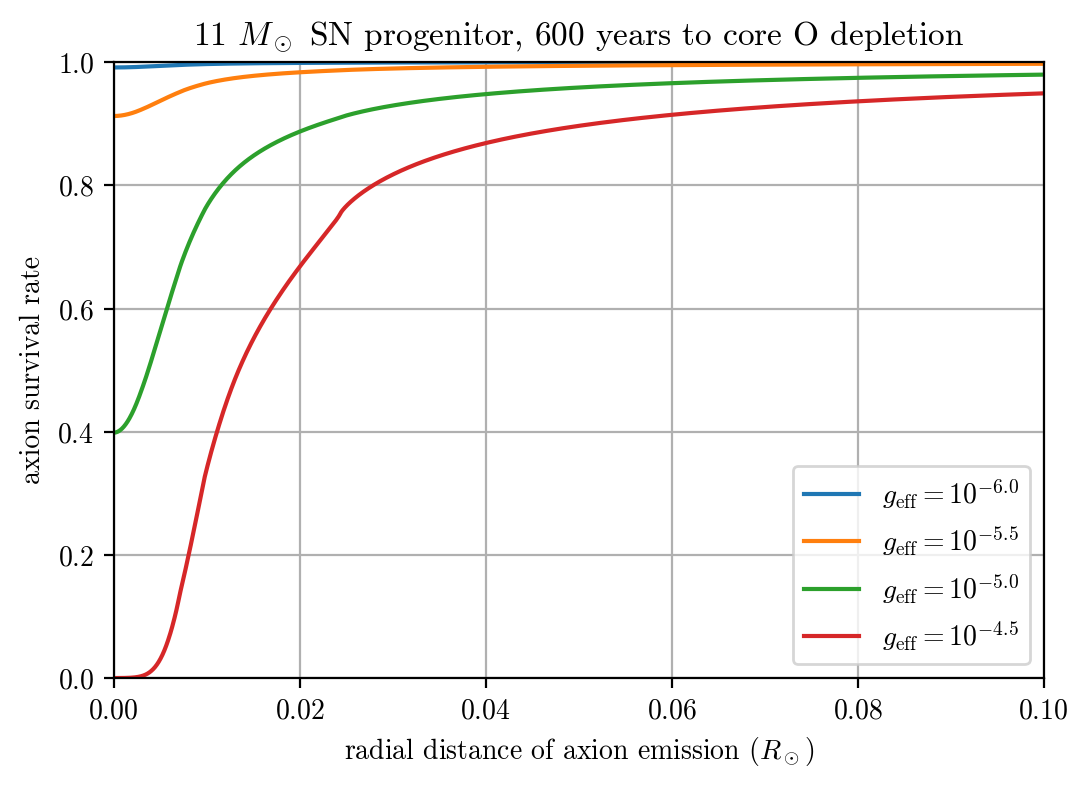

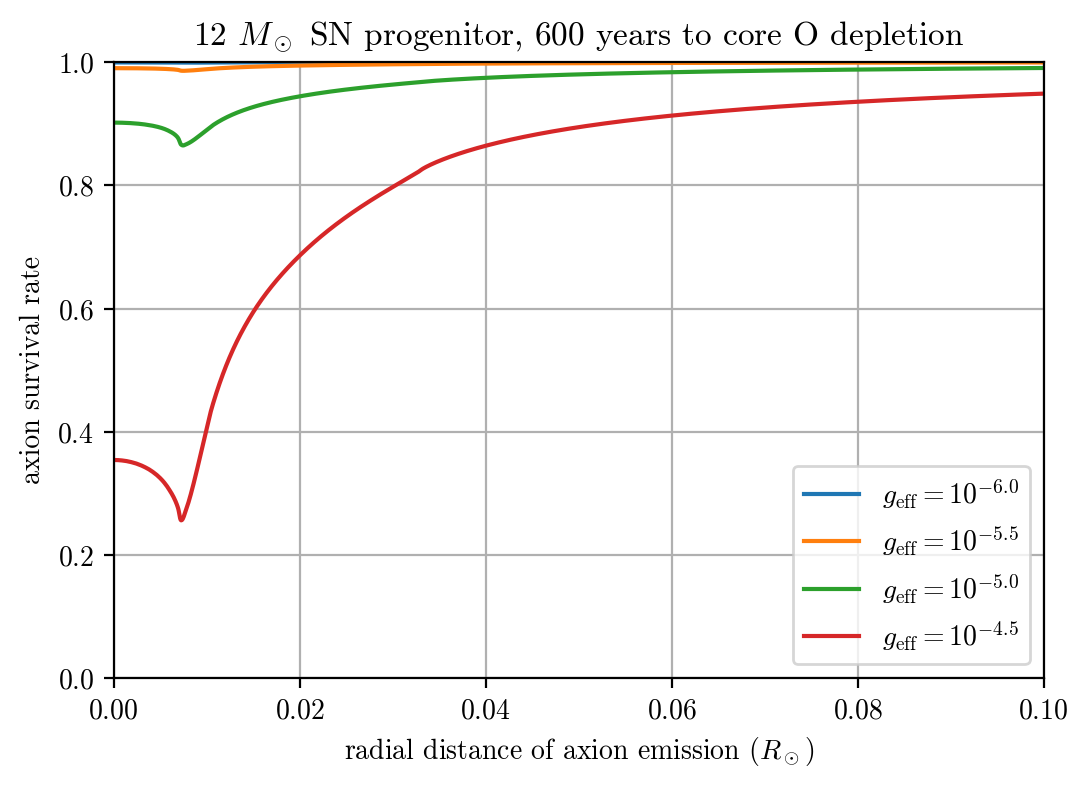

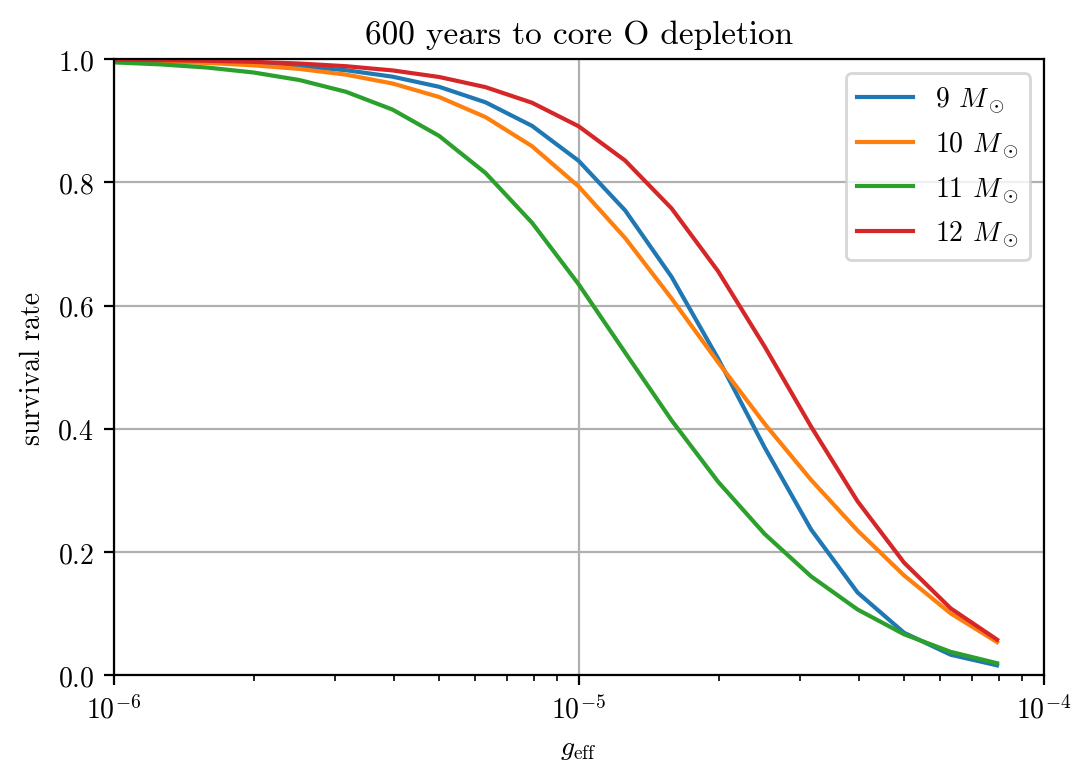

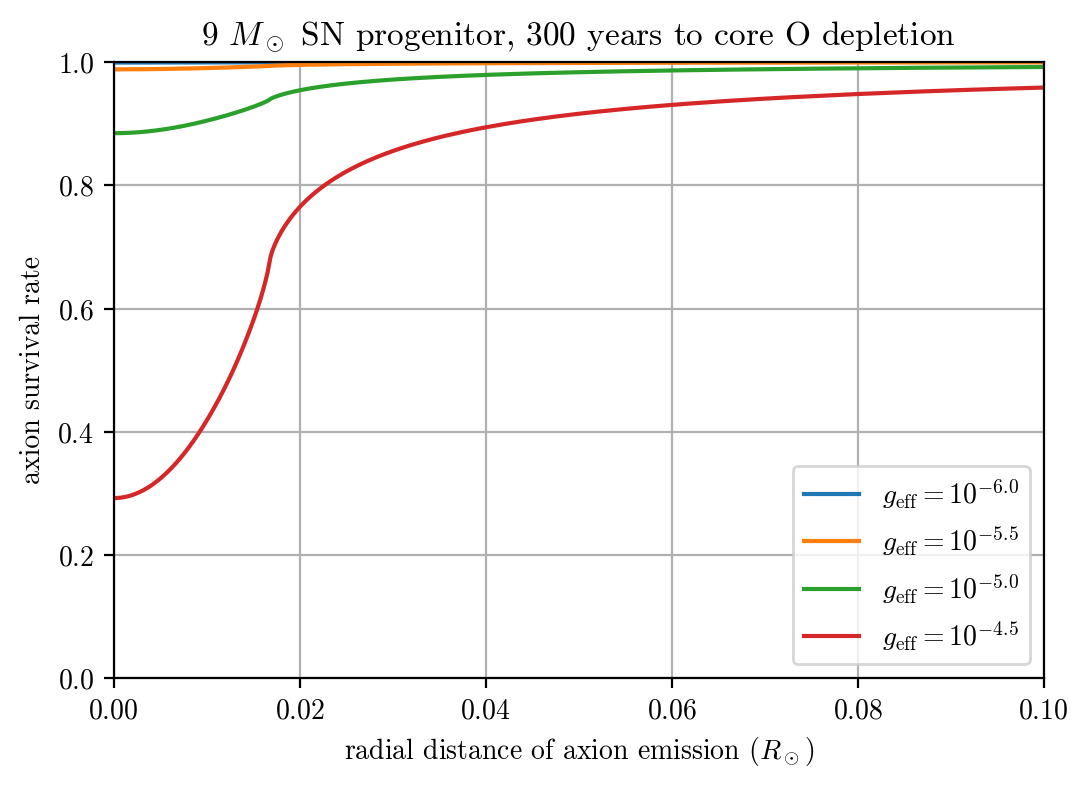

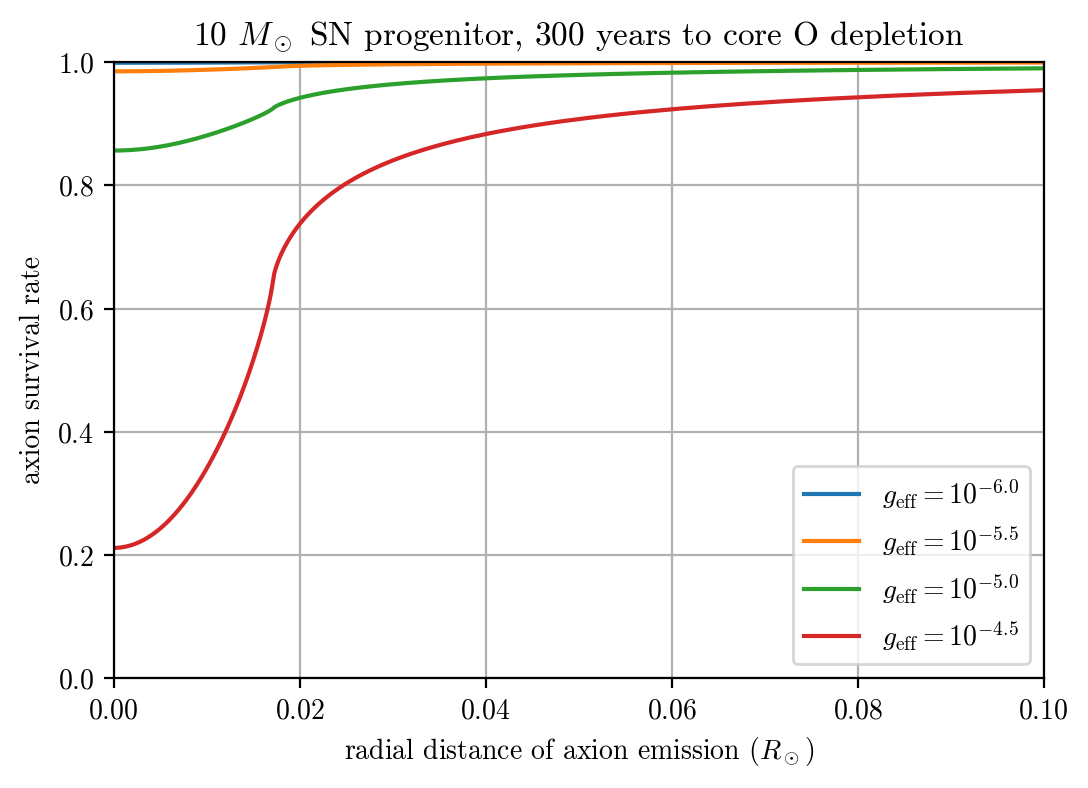

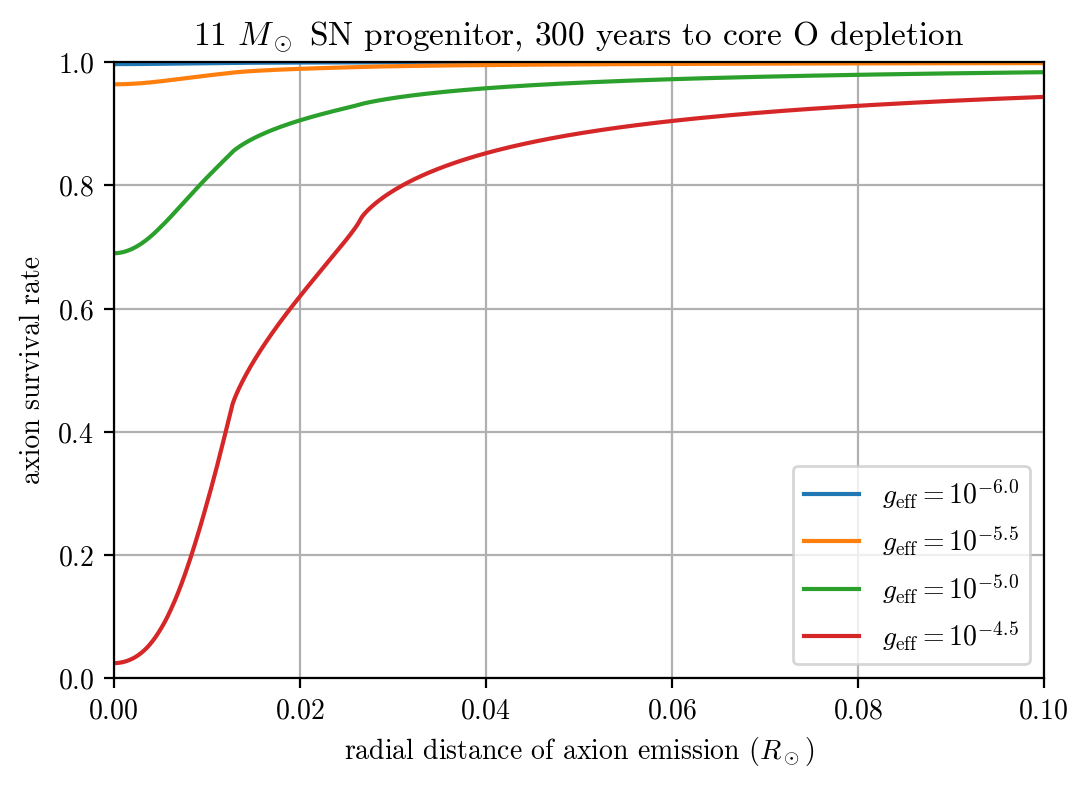

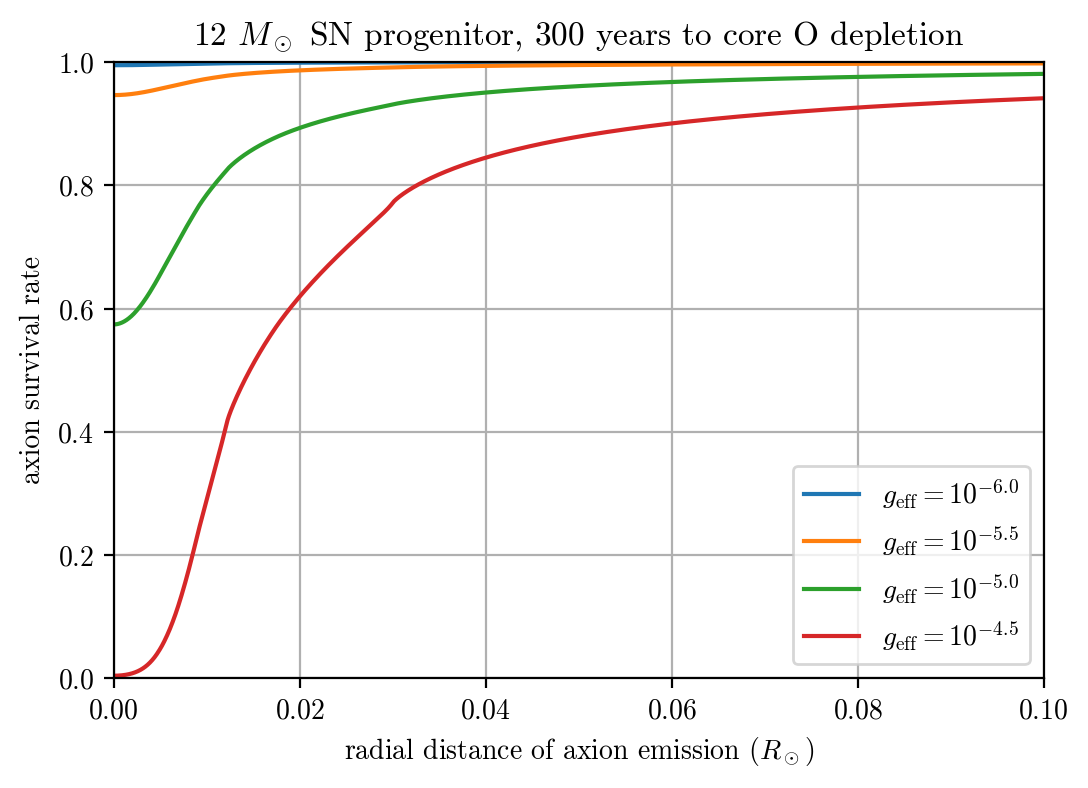

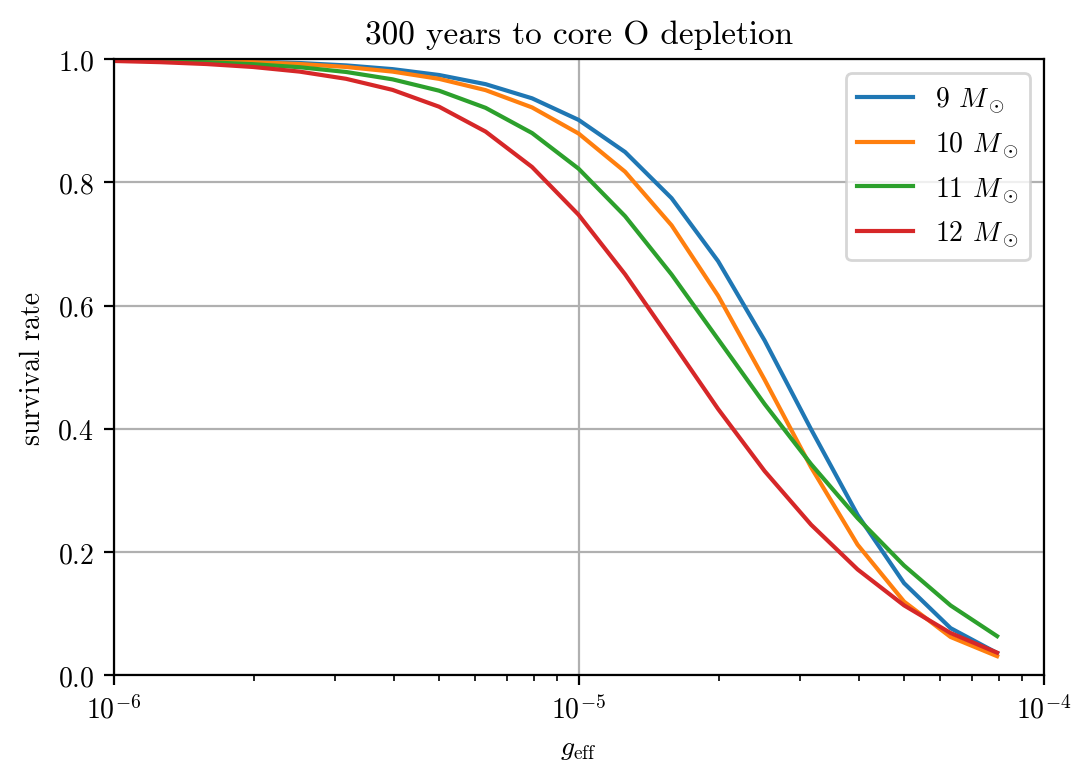

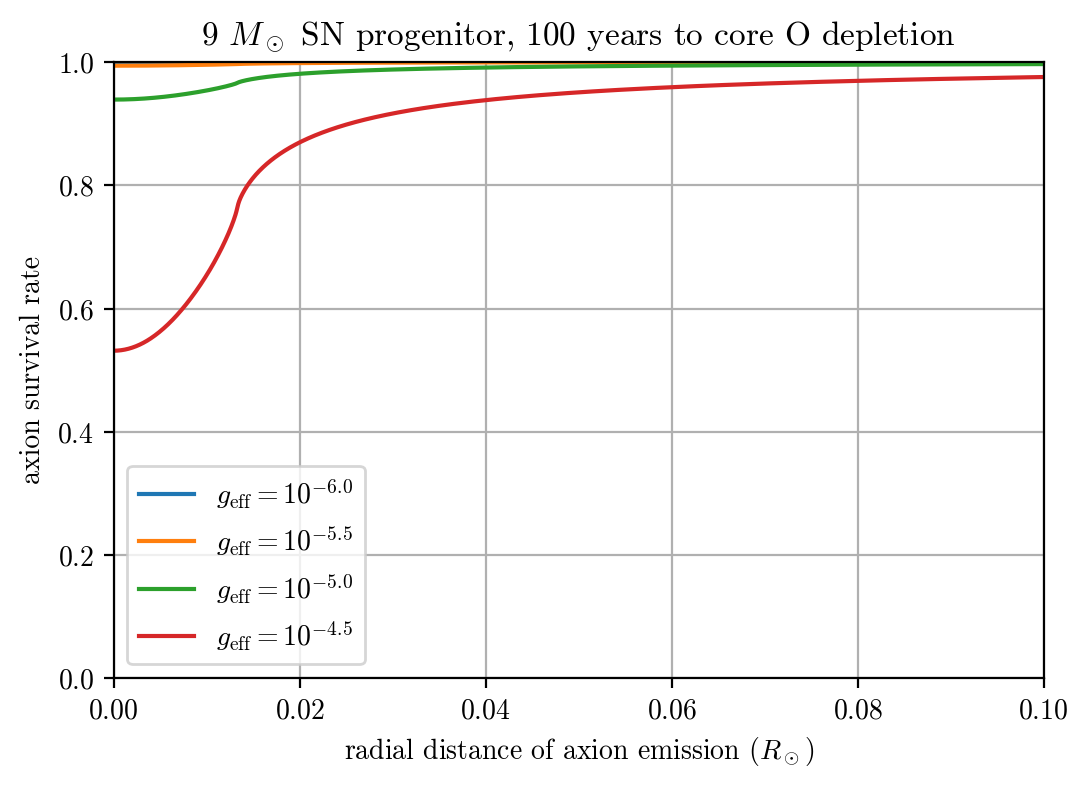

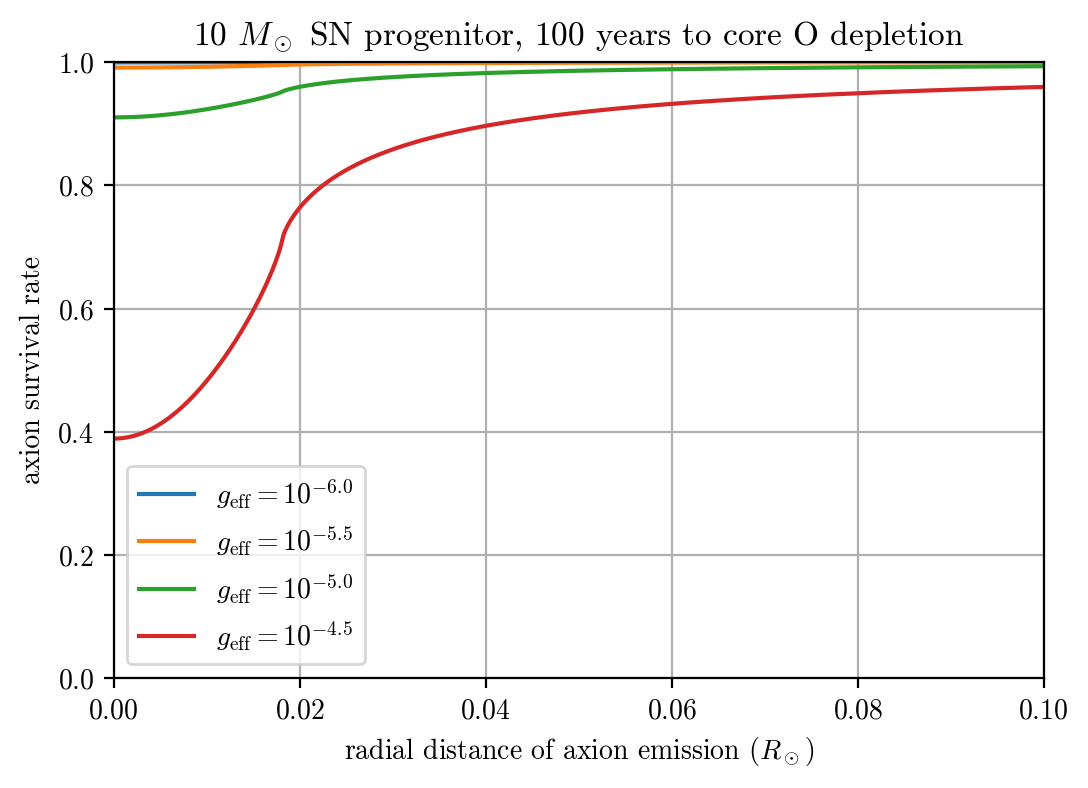

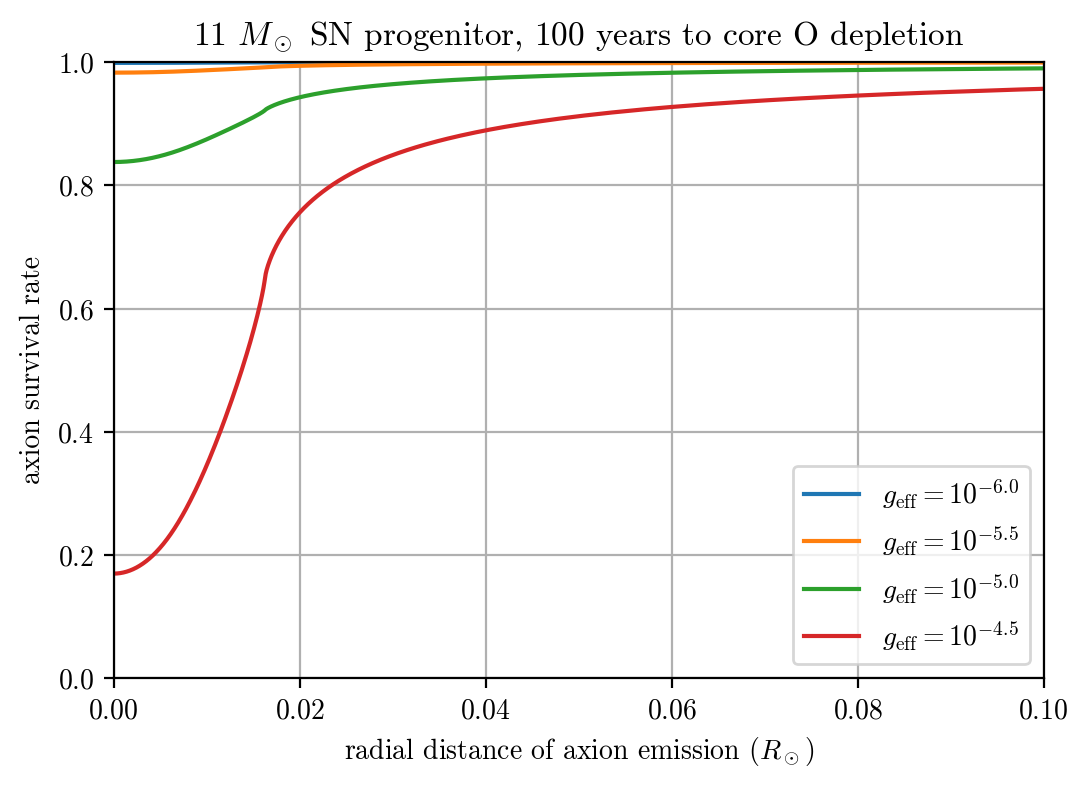

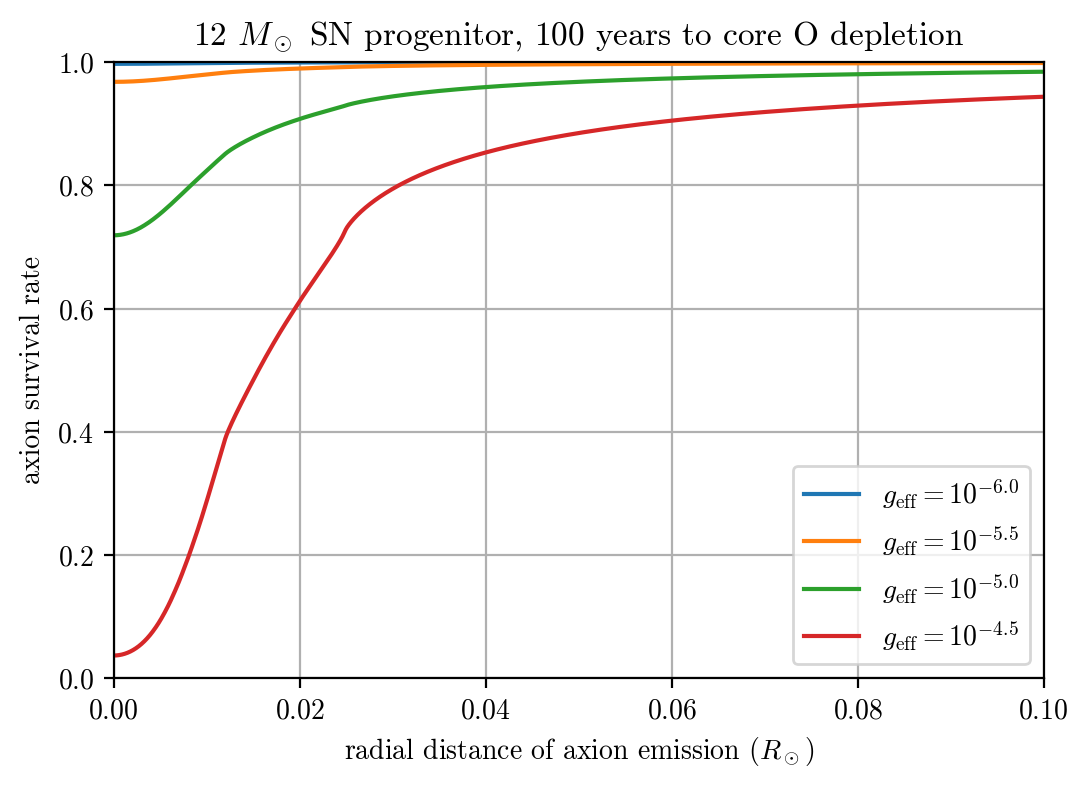

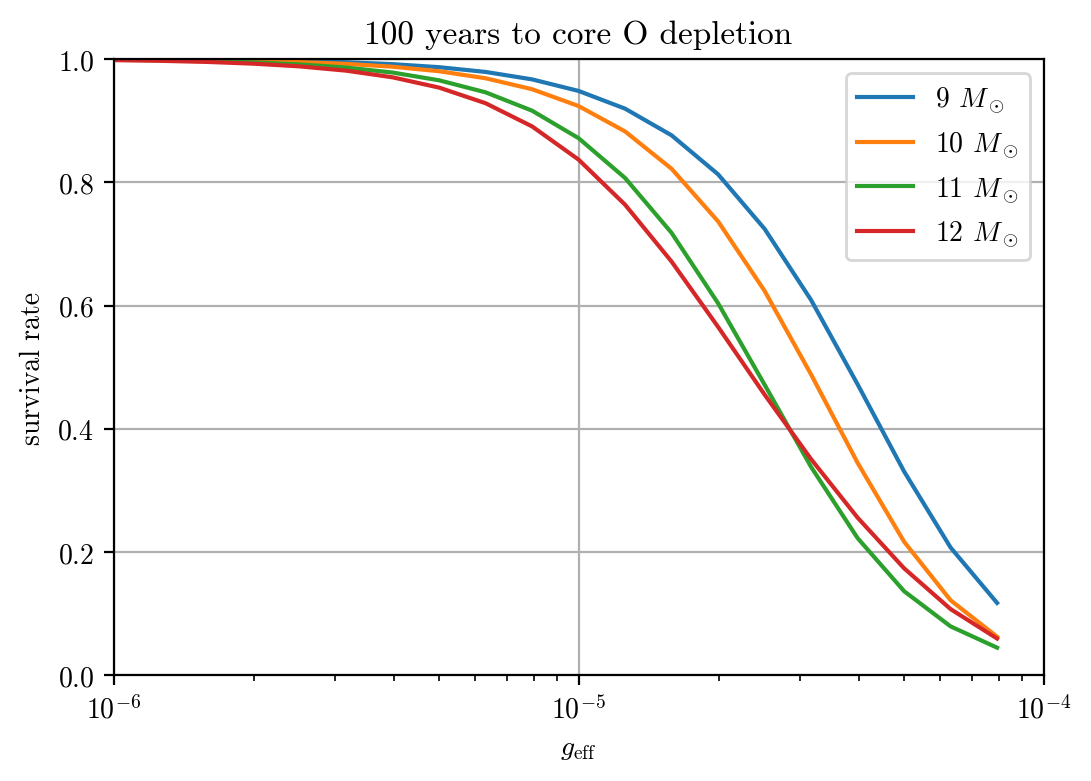

In [147]:
gg0 = -10
gg_ = np.arange(-6, -4, 0.1)
survival = np.zeros((len(ms), len(times), len(gg_)))
N = 2000

for (j, time) in enumerate(times):
    for (i, m) in enumerate(ms):
        key = f'm{m:04.1f}_g{gg0:+04.2f}_0'
        index = pd.read_csv(f'csv/{key}/index.csv')
        t = np.array(index["time to core O depletion (years)"])
    
        c = pd.read_csv(f'csv_simple_new/{m:02}_cores/core_{indices[i][j]}.csv')

        for (k, gg) in enumerate(gg_):
            g = 10**gg
            T8 = c['T8']
            sigma = np.sqrt(10/T8) * (g/1e-7)**2 * 1.195e-62 # Rsun^-2
            eps = c['axion emission density (s-1 Rsun-3)'] * (g/g0)**2
            n = c['X_na23'] * c['mass density (Msun Rsun-3)'] / (23*mp_per_Msun) # Rsun^-3
            r = c['radius (Rsun)'] # Rsun
            
            zz = np.linspace(-0.1, 0.1, N)
            bb = np.linspace(0, 0.1, N//2)
            dz = np.mean(np.diff(zz))
            z_, b_ = np.meshgrid(zz, bb)
            r_ = np.sqrt( z_**2 + b_**2 )
            
            tauzb = np.cumsum(np.interp(r_, r, n*sigma).T * dz, axis=0) # integrate to get total optical depth
            pzb = RegularGridInterpolator((zz, bb), np.exp(-tauzb)) # interpolate
            
            rr = np.linspace(0, 0.1, N)
            tt = np.linspace(0, np.pi, N)
            dr = np.mean(np.diff(rr))
            dt = np.mean(np.diff(tt))
            r_, t_ = np.meshgrid(rr, tt)
            pr = np.sum(pzb((r_*np.cos(t_), r_*np.sin(t_))) * dt, axis=0)/np.pi
            # pr.shape
            if int(gg * 10) % 5 == 0: plt.plot(rr, pr, label=f'$g_\mathrm{{eff}} = 10^{{{gg:.1f}}}$')
            eps_ = np.interp(rr, r, eps)
            survival[i][j][k] = np.sum(eps_ * pr * 4 * np.pi * rr * rr * dr) / np.sum(eps_ * 4 * np.pi * rr * rr * dr)
        
        plt.legend()
        plt.xlabel('radial distance of axion emission ($R_\odot$)')
        plt.ylabel('axion survival rate')
        plt.xlim(0, 0.1)
        plt.ylim(0, 1)
        plt.grid()
        plt.title(f'{m} $M_\odot$ SN progenitor, {time} years to core O depletion')
        plt.savefig(f'survive/survive_r_t{time:05}_m{m:02}.png')
        plt.show()
    
    for (i, m) in enumerate(ms):
        plt.plot(10**gg_, survival[i][j], label=f'{m} $M_\odot$')
    plt.xlim(1e-6, 1e-4)
    plt.ylim(0, 1)
    plt.legend()
    plt.gca().set_xscale('log')
    plt.xlabel('$g_\mathrm{{eff}}$')
    plt.ylabel('survival rate')
    plt.title(f'{time} years to core O depletion')
    plt.grid()
    plt.savefig(f'survive/survive_t{time:05}.png')
    plt.show()

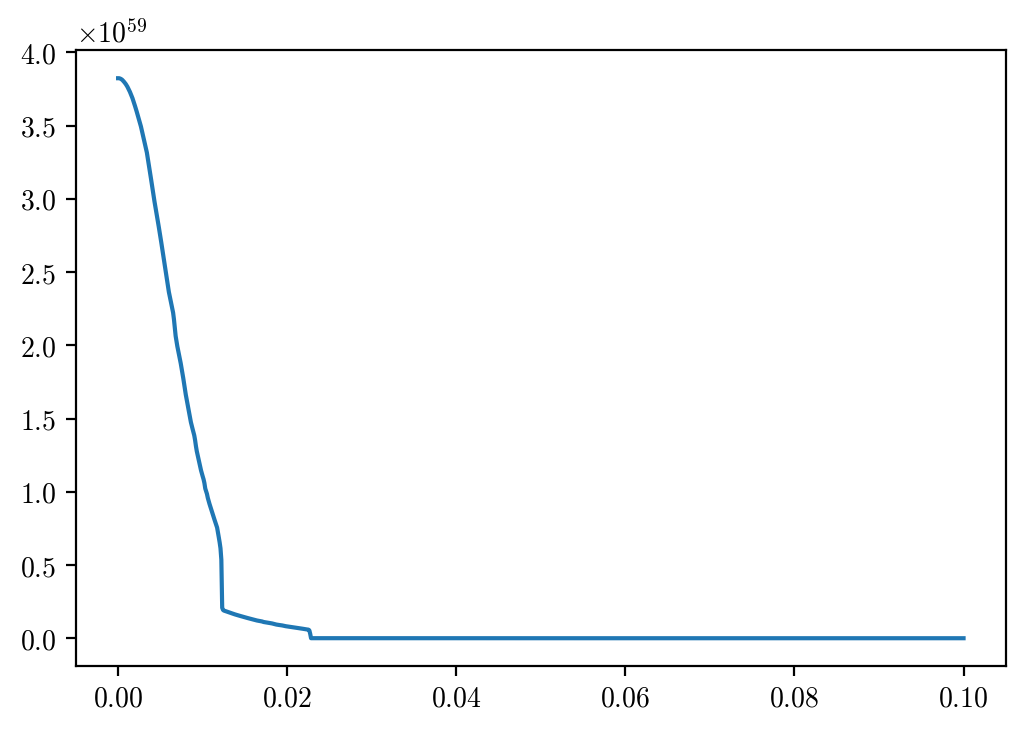

In [70]:
plt.plot(rr, n)